<a href="https://colab.research.google.com/github/Li-Hongmin/DMS_opt/blob/master/DMS_opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read data

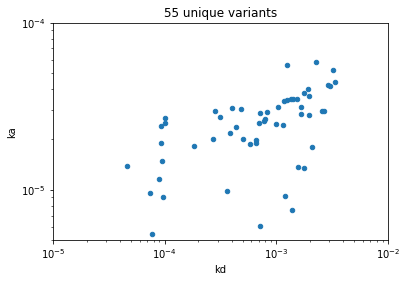

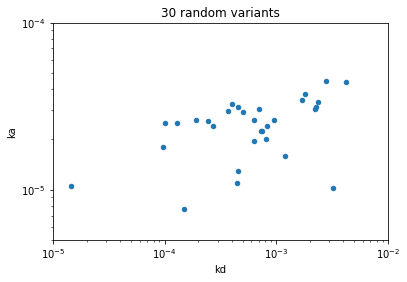

In [ ]:
import pandas as pd
import numpy as np
import requests
import io

def one_hot_encoder(s,  alphabet):
    """
    One hot encoding of a biological sequence.
    Parameters
    ---
    s: str, sequence which should be encoded
    alphabet: Alphabet object, downloaded from
        http://biopython.org/DIST/docs/api/Bio.Alphabet.IUPAC-module.html
    
    Example
    ---
    IUPAC_protein='ACDEFGHIKLMNPQRSTVWY'
    sequence = 'CARGSSYSSFAYW'
    one_hot_encoder(s=sequence, alphabet=IUPAC_protein)

    Returns
    ---
    x: array, n_size_alphabet, n_length_string
        Sequence as one-hot encoding
    """

    # Build dictionary
    d = {a: i for i, a in enumerate(alphabet)}

    # Encode
    x = np.zeros((len(d), len(s)))
    x[[d[c] for c in s], range(len(s))] = 1

    return x


def one_hot_decoder(x, alphabet):
    """
    Decodes a one-hot encoding to a biological sequence
    Parameters
    ---
    x: array, n_size_alphabet, n_length_string
        Sequence as one-hot encoding
    alphabet: Alphabet object, downloaded from
        http://biopython.org/DIST/docs/api/Bio.Alphabet.IUPAC-module.html
    Example
    ---
    encoding = one_hot_encoder(sequence, IUPAC.unambiguous_dna)
    one_hot_decoder(encoding, IUPAC.unambiguous_dna)
    Returns
    ---
    s : str, decoded sequence
    """

    d = {a: i for i, a in enumerate(alphabet)}
    inv_d = {i: a for a, i in d.items()}
    s = (''.join(str(inv_d[i]) for i in np.argmax(x, axis=0)))

    return s


url = "https://raw.githubusercontent.com/Li-Hongmin/DMS_opt/master/data/Supplementary%20Table%206-%20Calculated%20parameters%20for%20the%2060%20identified%20variants%2055.csv"
s = requests.get(url).content
data_55 = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col = [0]).dropna()
tmp_idx = data_55['ka'] > 1e-4
data_55.loc[tmp_idx, 'ka'] = data_55.loc[tmp_idx, 'ka'] * 1e-2
ax1 = data_55.plot.scatter(x= 'kd', y = 'ka')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(1e-5,1e-2)
ax1.set_ylim(5e-6,1e-4)
ax1.set_title('55 unique variants')

url = "https://raw.githubusercontent.com/Li-Hongmin/DMS_opt/master/data/fig4c_data.csv"
s = requests.get(url).content
data_30 = pd.read_csv(io.StringIO(s.decode('utf-8')), index_col = [0]).dropna()
ax2 = data_30.plot.scatter(x= 'kd', y = 'ka')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim(1e-5,1e-2)
ax2.set_ylim(5e-6,1e-4)
ax2.set_title('30 random variants')
# combine two datasets
data_30 = data_30.drop(index=['WT-Tra '])
data_30.index = ['random ' + str(i) for i in data_30.index]
data = data_30.append(data_55[['AASeq','ka', 'kd']])

# encoder
IUPAC_protein='ACDEFGHIKLMNPQRSTVWY'

X = data.loc[:, 'AASeq'].values
y_ka = data.loc[:, 'ka'].values
y_kd = data.loc[:, 'kd'].values
# One hot encode the sequences
X = [one_hot_encoder(s=x, alphabet=IUPAC_protein) for x in X]
X = [x.flatten('F') for x in X]
X = np.array(X)

# Regression setting

In [ ]:
def model_score(reg, X, y):
    from sklearn.model_selection import cross_val_predict
    from sklearn.model_selection import LeaveOneOut
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import mean_absolute_percentage_error, r2_score
    from sklearn.preprocessing import MinMaxScaler
    
    cv = LeaveOneOut()
    y_pred = cross_val_predict(reg, X, y, cv=cv)
    
    scores = {}
    scores['mean_absolute_error'] = mean_absolute_error(y, y_pred)
    scores['mean_squared_error'] = mean_squared_error(y, y_pred)
    # print(y_pred.min()>0)
    # scores['mean_squared_log_error'] = mean_squared_log_error(y, y_pred)
    scores['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y, y_pred)
    scores['r2_score'] = r2_score(y, y_pred)
    
    
    return scores

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
kd_mse = model_score(reg, X, y_kd)
ka_mse = model_score(reg, X, y_ka)
print(ka_mse,kd_mse)

{'mean_absolute_error': 6.885270011963692e-06, 'mean_squared_error': 7.581823352875976e-11, 'mean_absolute_percentage_error': 0.365883994240641, 'r2_score': 0.3754057670959545} {'mean_absolute_error': 0.0007692173725071246, 'mean_squared_error': 1.0623243917296302e-06, 'mean_absolute_percentage_error': 1.741160540937814, 'r2_score': -0.1683082923476913}


In [ ]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
ka_mse = model_score(reg, X, y_ka)
kd_mse = model_score(reg, X, y_kd)
print(ka_mse,kd_mse)

{'mean_absolute_error': 8.618588235294118e-06, 'mean_squared_error': 1.2426097096193774e-10, 'mean_absolute_percentage_error': 0.5109916587581056, 'r2_score': -0.023667820069204204} {'mean_absolute_error': 0.0007875049521203829, 'mean_squared_error': 9.308050806546712e-07, 'mean_absolute_percentage_error': 3.3250909542819205, 'r2_score': -0.023667820069204426}


In [ ]:
from sklearn import linear_model
reg = linear_model.RidgeCV()
ka_mse = model_score(reg, X, y_ka)
kd_mse = model_score(reg, X, y_kd)
print(ka_mse,kd_mse)

{'mean_absolute_error': 5.839164313411292e-06, 'mean_squared_error': 5.4987179520864583e-11, 'mean_absolute_percentage_error': 0.3106945518765069, 'r2_score': 0.547012986007335} {'mean_absolute_error': 0.0006506606343130346, 'mean_squared_error': 7.328789638530498e-07, 'mean_absolute_percentage_error': 1.9097835801315421, 'r2_score': 0.19400460215111126}


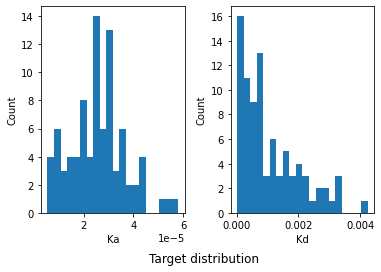

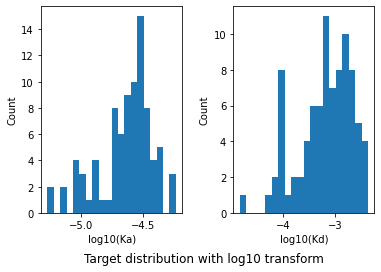

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_ka, bins=20,)
# ax0.set_xlim([0, 2000])
ax0.set_ylabel("Count")
ax0.set_xlabel("Ka")
# ax0.set_title("Target distribution")

ax1.hist(y_kd, bins=20,)
ax1.set_ylabel("Count")
ax1.set_xlabel("Kd")
# ax1.set_title("Transformed target distribution")

f.suptitle("Target distribution", y=0.06, x=0.53)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(np.log10(y_ka), bins=20,)
# ax0.set_xlim([0, 2000])
ax0.set_ylabel("Count")
ax0.set_xlabel("log10(Ka)")
# ax0.set_title("Target distribution")

ax1.hist(np.log10(y_kd), bins=20,)
ax1.set_ylabel("Count")
ax1.set_xlabel("log10(Kd)")
# ax1.set_title("Transformed target distribution")

f.suptitle("Target distribution with log10 transform", y=0.06, x=0.53)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])


# RidgeCV

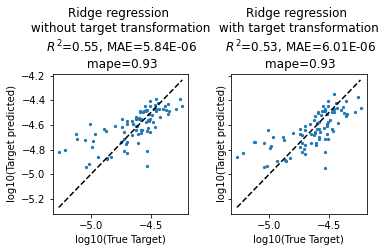

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import exp10

cv = LeaveOneOut()
reg = RidgeCV()
y_pred = cross_val_predict(reg, X, y_ka, cv=cv)
# Plot results
ax0.scatter(np.log10(y_ka), np.log10(y_pred), s=5)
ax0.plot([np.log10(y_ka).min(), np.log10(y_ka).max()], 
         [np.log10(y_ka).min(), np.log10(y_ka).max()], "--k")
ax0.set_ylabel("log10(Target predicted)")
ax0.set_xlabel("log10(True Target)")
ax0.set_title("Ridge regression \n without target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2E"
              % (r2_score(y_ka, y_pred), mean_absolute_error(y_ka, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred)))

# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log10, inverse_func=exp10
)

y_pred = cross_val_predict(regr_trans, X, y_ka, cv=cv)

# ax1.scatter(y_ka, y_pred, s=5)
ax1.scatter(np.log10(y_ka), np.log10(y_pred), s=5)
ax1.plot([np.log10(y_ka).min(), np.log10(y_ka).max()], 
         [np.log10(y_ka).min(), np.log10(y_ka).max()], "--k")
ax1.set_ylabel("log10(Target predicted)")
ax1.set_xlabel("log10(True Target)")
ax1.set_title("Ridge regression \n with target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2E"
              % (r2_score(y_ka, y_pred), mean_absolute_error(y_ka, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred)))

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

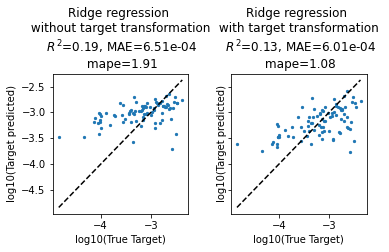

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import exp10

cv = LeaveOneOut()
reg = RidgeCV()
y_pred = cross_val_predict(reg, X, y_kd, cv=cv)
# Plot results
ax0.scatter(np.log10(y_kd), np.log10(y_pred), s=5)
ax0.plot([np.log10(y_kd).min(), np.log10(y_kd).max()], 
         [np.log10(y_kd).min(), np.log10(y_kd).max()], "--k")
ax0.set_ylabel("log10(Target predicted)")
ax0.set_xlabel("log10(True Target)")
ax0.set_title("Ridge regression \n without target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2e"
              % (r2_score(y_kd, y_pred), mean_absolute_error(y_kd, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred))
              )

# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(), func=np.log10, inverse_func=exp10
)

y_pred = cross_val_predict(regr_trans, X, y_kd, cv=cv)

# ax1.scatter(y_kd, y_pred, s=5)
ax1.scatter(np.log10(y_kd), np.log10(y_pred), s=5)
ax1.plot([np.log10(y_kd).min(), np.log10(y_kd).max()], 
         [np.log10(y_kd).min(), np.log10(y_kd).max()], "--k")
ax1.set_ylabel("log10(Target predicted)")
ax1.set_xlabel("log10(True Target)")
ax1.set_title("Ridge regression \n with target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2e"
              % (r2_score(y_kd, y_pred), mean_absolute_error(y_kd, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred))
              )

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

#RandomForest

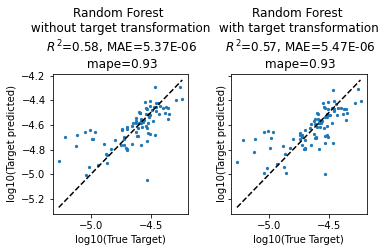

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import exp10

cv = LeaveOneOut()
reg = RandomForestRegressor(random_state=0)
y_pred = cross_val_predict(reg, X, y_ka, cv=cv)
# Plot results
ax0.scatter(np.log10(y_ka), np.log10(y_pred), s=5)
ax0.plot([np.log10(y_ka).min(), np.log10(y_ka).max()], 
         [np.log10(y_ka).min(), np.log10(y_ka).max()], "--k")
ax0.set_ylabel("log10(Target predicted)")
ax0.set_xlabel("log10(True Target)")
ax0.set_title("Random Forest \n without target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2E"
              % (r2_score(y_ka, y_pred), mean_absolute_error(y_ka, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred)))

# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=0), func=np.log10, inverse_func=exp10
)

y_pred = cross_val_predict(regr_trans, X, y_ka, cv=cv)

# ax1.scatter(y_ka, y_pred, s=5)
ax1.scatter(np.log10(y_ka), np.log10(y_pred), s=5)
ax1.plot([np.log10(y_ka).min(), np.log10(y_ka).max()], 
         [np.log10(y_ka).min(), np.log10(y_ka).max()], "--k")
ax1.set_ylabel("log10(Target predicted)")
ax1.set_xlabel("log10(True Target)")
ax1.set_title("Random Forest \n with target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2E"
              % (r2_score(y_ka, y_pred), mean_absolute_error(y_ka, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred)))

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

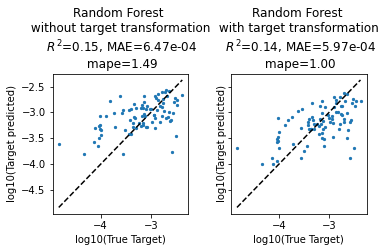

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
# Use linear model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import exp10
from sklearn.ensemble import RandomForestRegressor

cv = LeaveOneOut()

reg = RandomForestRegressor(random_state=0)
y_pred = cross_val_predict(reg, X, y_kd, cv=cv)
# Plot results
ax0.scatter(np.log10(y_kd), np.log10(y_pred), s=5)
ax0.plot([np.log10(y_kd).min(), np.log10(y_kd).max()], 
         [np.log10(y_kd).min(), np.log10(y_kd).max()], "--k")
ax0.set_ylabel("log10(Target predicted)")
ax0.set_xlabel("log10(True Target)")
ax0.set_title("Random Forest \n without target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2e"
              % (r2_score(y_kd, y_pred), mean_absolute_error(y_kd, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred))
              )

# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=RandomForestRegressor(random_state=0), func=np.log10, inverse_func=exp10
)

y_pred = cross_val_predict(regr_trans, X, y_kd, cv=cv)

# ax1.scatter(y_kd, y_pred, s=5)
ax1.scatter(np.log10(y_kd), np.log10(y_pred), s=5)
ax1.plot([np.log10(y_kd).min(), np.log10(y_kd).max()], 
         [np.log10(y_kd).min(), np.log10(y_kd).max()], "--k")
ax1.set_ylabel("log10(Target predicted)")
ax1.set_xlabel("log10(True Target)")
ax1.set_title("Random Forest \n with target transformation \n "+
              r"$R^2$=%.2f, MAE=%.2e"
              % (r2_score(y_kd, y_pred), mean_absolute_error(y_kd, y_pred))
              +"\n "
              +r"mape=%.2f"
              % (mean_absolute_percentage_error(y_kd, y_pred))
              )

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])